The following are important libraries for data analysis and machine learning:

- numpy: A library for scientific computing that offers data structures for arrays and matrices, along with mathematical functions.
pandas: A library for data analysis and manipulation, specifically designed for numerical tables and time series data.
- tensorflow: An open-source platform for machine learning that enables the development and deployment of different types of neural networks.
tensorflow_addons: A library that extends the capabilities of TensorFlow by introducing new functionalities not found in its core.
- matplotlib: A plotting library that creates high-quality graphics in various formats and interactive environments.
- tqdm: A Python and command-line interface progress bar that is fast and customizable.
- sklearn: A machine learning library that includes algorithms for classification, regression, clustering, dimensionality reduction, model selection, and preprocessing.
- math: A module that provides access to mathematical functions defined in the C standard.
- scipy: A scientific computing library with efficient numerical routines for tasks such as integration, interpolation, optimization, linear algebra, and statistics.

In [13]:
import math
import scipy

import numpy as np
import pandas as pd
import tensorflow as tf

!pip install tensorflow-addons
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit 
from sklearn.metrics import classification_report

import sys
print(f'Python V{sys.version}')

!pip install tflite-runtime
import tflite_runtime.interpreter as tflite

Python V3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 9.9 MB/s eta 0:00:00:00:01:00:01


# Graphing Config

In [14]:
#Set the font size of x-axis and y-axis tick labels to 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

#Set the font size of axis labels and titles to 18 and 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 24

# Training Parameter Configuration


In [15]:
N_ROWS = 543 # Number of rows
N_DIMS = 3 # Number of dimensions
NUM_CLASSES = 250
SEED = 42 # Random seed
INPUT_SIZE = 64 # Input size
N_EPOCHS = 90

# Read in the training data
### Note that the samples need to have their path adjusted to match Kaggle's path

In [16]:
# Read Training Data
train = pd.read_csv('/kaggle/input/asl-signs/train.csv')
train['path'] = train['path'].apply(lambda path: f'/kaggle/input/asl-signs/{path}')
N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 94477


# Digitally encode symbols

In [17]:
train['sign_ord'] = train['sign'].astype('category').cat.codes
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

# Statistical video data

In [18]:
train.sample(20)

,path,participant_id,sequence_id,sign,sign_ord
52347,/kaggle/input/asl-signs/train_landmark_files/5...,53618,3142327930,bed,17
28784,/kaggle/input/asl-signs/train_landmark_files/4...,4718,2185446281,talk,212
63143,/kaggle/input/asl-signs/train_landmark_files/2...,26734,3589101179,blue,26
23372,/kaggle/input/asl-signs/train_landmark_files/2...,22343,1963256269,girl,94
48873,/kaggle/input/asl-signs/train_landmark_files/6...,61333,2997921668,time,220
86126,/kaggle/input/asl-signs/train_landmark_files/5...,55372,655083005,tongue,222
56112,/kaggle/input/asl-signs/train_landmark_files/1...,16069,3294180639,lips,134
77045,/kaggle/input/asl-signs/train_landmark_files/1...,18796,4153756711,tooth,223
78472,/kaggle/input/asl-signs/train_landmark_files/6...,62590,4212521588,finger,80
45146,/kaggle/input/asl-signs/train_landmark_files/3...,32319,2844286654,high,117


In [19]:
train.isna().sum()

path              0
participant_id    0
sequence_id       0
sign              0
sign_ord          0
dtype: int64

# Calculate frame statistics
The next piece of code calculates statistics for different video frames in a video dataset. The variables unique_frames, missing_frames, and max_frame store the respective values for the number of distinct frames, missing frames, and maximum frames.

Within a loop, the code goes through each video in the dataset. It reads the video data, counts the number of distinct frames, missing frames, and maximum frames for each video.

Finally, the code presents these statistics and generates a histogram to visualize the data.

In [20]:
N = int(10e3)
SEED = 42

def calculate_stats(df):
    unique_frames = df['frame'].nunique()
    missing_frames = (df['frame'].max() - df['frame'].min()) - unique_frames + 1
    max_frame = df['frame'].max()

    return unique_frames, missing_frames, max_frame

def process_files(file_paths, n_samples, seed):
    unique_frames_count = np.zeros(n_samples, dtype=np.uint16)
    missing_frames_count = np.zeros(n_samples, dtype=np.uint16)
    max_frame_count = np.zeros(n_samples, dtype=np.uint16)

    for idx, file_path in enumerate(tqdm(file_paths.sample(n_samples, random_state=seed))):
        df = pd.read_parquet(file_path)
        unique_frames, missing_frames, max_frame = calculate_stats(df)

        unique_frames_count[idx] = unique_frames
        missing_frames_count[idx] = missing_frames
        max_frame_count[idx] = max_frame

    return unique_frames_count, missing_frames_count, max_frame_count

unique_frames, missing_frames, max_frames = process_files(train['path'], N, SEED)

  0%|          | 0/10000 [00:00<?, ?it/s]

,unique_frames
count,10000.000000
mean,37.715800
std,44.396943
min,2.000000
1%,6.000000
5%,6.000000
25%,12.000000
50%,22.000000
75%,43.000000
95%,133.000000


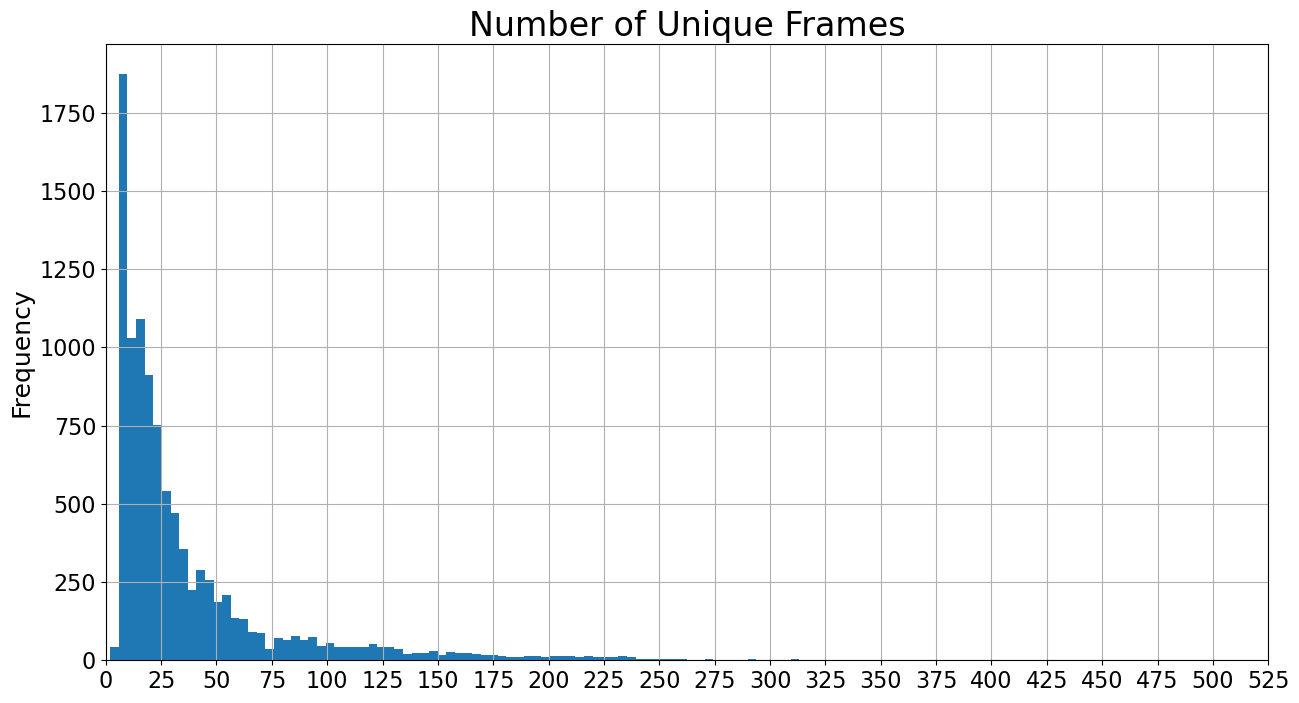

In [21]:
# Number of unique frames in each video
PERCENTILES = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 0.999] 
display(pd.Series(unique_frames).describe(percentiles=PERCENTILES).to_frame('unique_frames'))

plt.figure(figsize=(15,8))
plt.title('Number of Unique Frames', size=24)
pd.Series(unique_frames).plot(kind='hist', bins=128)
plt.grid()
xlim = math.ceil(plt.xlim()[1])
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+25, 25))
plt.show()

,missing_frames
count,10000.000000
mean,0.004500
std,0.291699
min,0.000000
1%,0.000000
5%,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
95%,0.000000


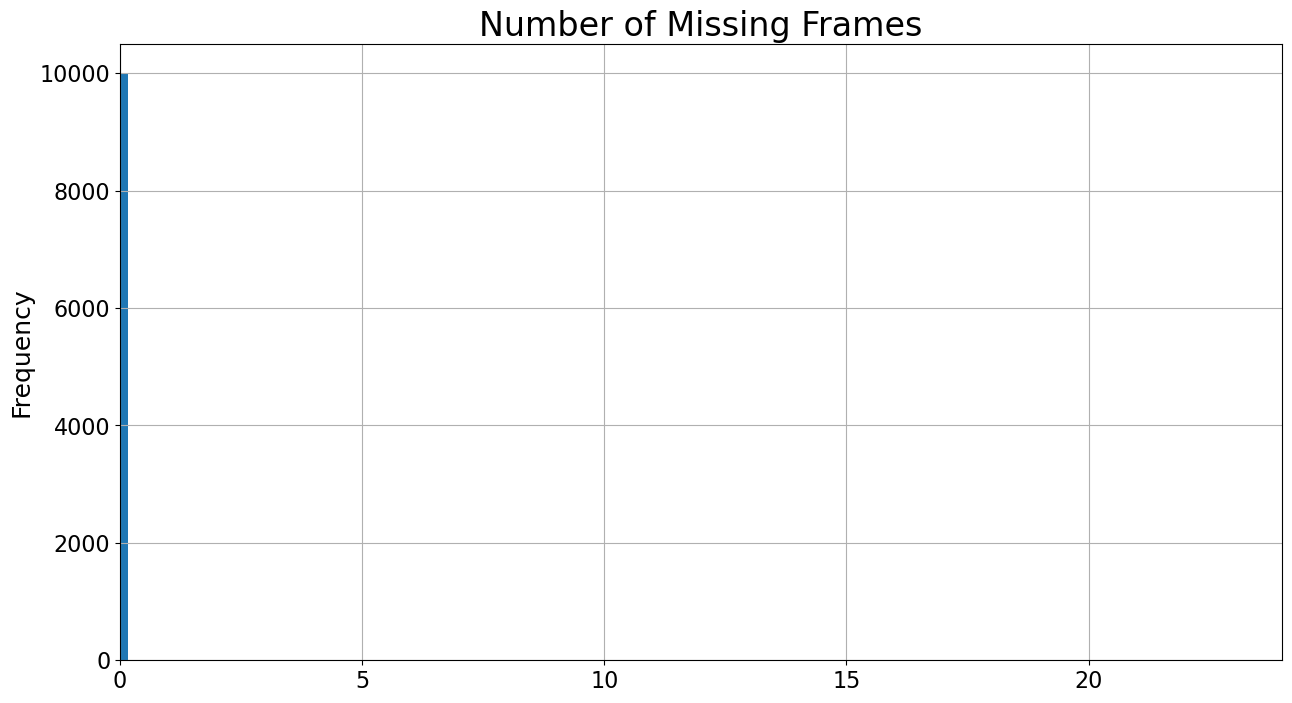

In [22]:
# Number of missing frames, consecutive frames with missing intermediate frame, i.e. 1,2,4,5 -> 3 is missing
#The number of lost frames, the consecutive frames lost in the middle frame
display(pd.Series(missing_frames).describe(percentiles=PERCENTILES).to_frame('missing_frames'))

plt.figure(figsize=(15,8))
plt.title('Number of Missing Frames', size=24)
pd.Series(missing_frames).plot(kind='hist', bins=128)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

,max_frames
count,10000.000000
mean,67.391300
std,59.145194
min,1.000000
1%,12.990000
5%,22.000000
25%,33.000000
50%,42.000000
75%,63.000000
95%,201.000000


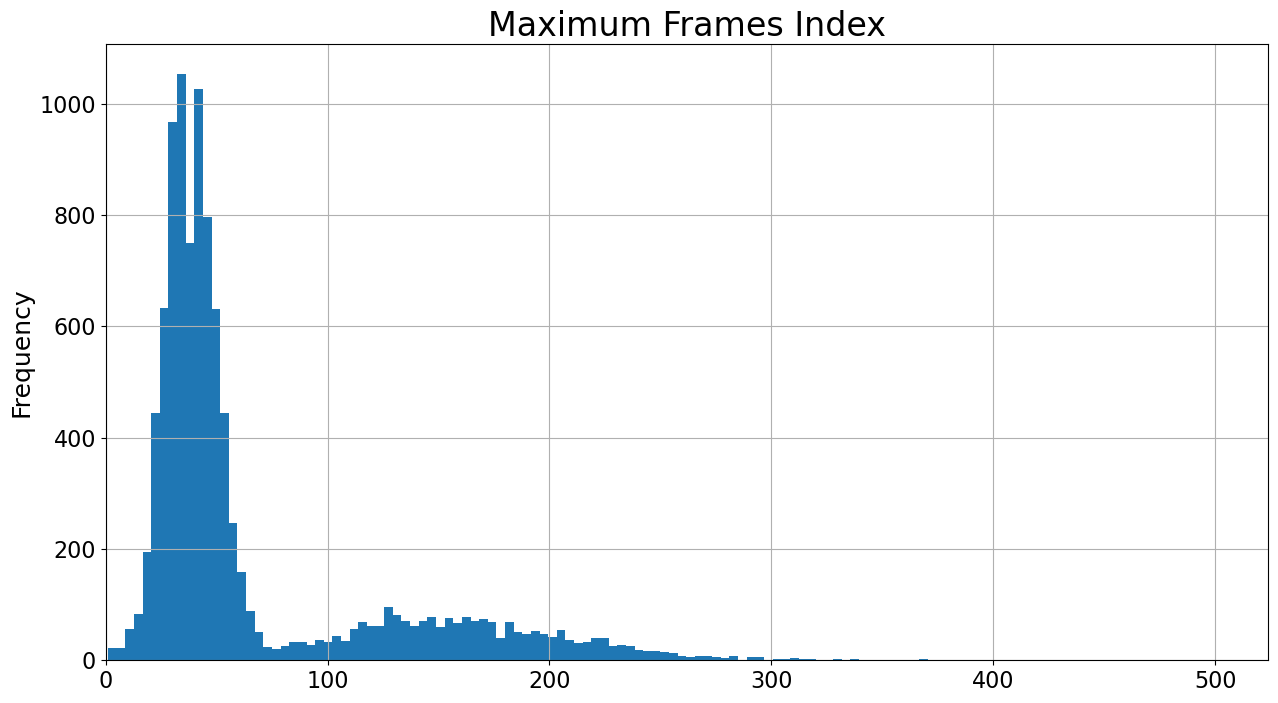

In [23]:
# Maximum frame number
display(pd.Series(max_frames).describe(percentiles=PERCENTILES).to_frame('max_frames'))

plt.figure(figsize=(15,8))
plt.title('Maximum Frames Index', size=24)
pd.Series(max_frames).plot(kind='hist', bins=128)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

# Landmark Indices key point index

In the field of machine learning, Landmark Indices typically pertain to the numeric representation of facial keypoints. Facial keypoints denote specific points on a face, including eyes, nose, mouth, and more. These keypoints serve various purposes such as face recognition and expression analysis. Within machine learning, these keypoints can be utilized to train models for tasks like facial recognition

In [24]:
#Define the lip landmark indices in the original data (total 40)
lips_indices = np.array([
61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
])

#Define the left hand landmark indices in the original data (total 21)
LEFT_HAND_IDXS0 = np.arange(468, 489)

#Define the right hand landmark indices in the original data (total 21)
RIGHT_HAND_IDXS0 = np.arange(522, 543)

#Define the left pose landmark indices in the original data (total 5)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])

#Define the right pose landmark indices in the original data (total 5)
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])

#Define the left-dominant landmark indices, including lips, left hand, and left pose (total 66)
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((lips_indices, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))

#Define the right-dominant landmark indices, including lips, right hand, and right pose (total 66)
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((lips_indices, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))

#Define all hand landmark indices, including left hand and right hand (total 42)
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)

#Define the number of columns in the processed data (equals to 66)
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size

#Define the lip landmark indices in the processed data (from 0 to 39)
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, lips_indices)).squeeze()

#Define the left hand landmark indices in the processed data (from 40 to 60)
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()

#Define the right hand landmark indices in the processed data (from 40 to 60)
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()

#Define all hand landmark indices in the processed data (from 40 to 81)
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()

#Define the pose landmark indices in the processed data (from 61 to 65)
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

#Define the starting position of lip landmarks, which is 0
LIPS_START = 0

#Define the starting position of left hand landmarks, which is the number of lip landmarks
LEFT_HAND_START = LIPS_IDXS.size

#Define the starting position of right hand landmarks, which is the starting position of left hand landmarks plus the number of left hand landmarks
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size

#Define the starting position of pose landmarks, which is the starting position of right hand landmarks plus the number of right hand landmarks
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

#Print the starting positions of different landmarks
print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

# Process Data Tensorflow


In this code snippet, a constant named ROWS_PER_FRAME is introduced with a unique value of 543, symbolizing the count of distinctive landmarks present in each frame. The function load_relevant_data_subset(pq_path) is responsible for examining the parquet file specified by the provided path. It specifically extracts three columns of data, namely x, y, and z, from the dataset.

Subsequently, the data set is segregated based on the number of landmarks contained within each frame, ultimately producing a three-dimensional array. The first dimension of this array corresponds to the total number of frames, while the second dimension signifies the count of landmarks per frame. The third dimension conveniently represents the x, y, and z coordinate axes.

The resultant array is of type numpy.ndarray, and its data type is np.float32. The function diligently ensures the integrity and precision of the returned data.

In [26]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    
    n_frames = len(data) // ROWS_PER_FRAME
    reshaped_data = data.to_numpy().reshape(n_frames, ROWS_PER_FRAME, -1)
    
    return reshaped_data.astype(np.float32)

# Create Dataset

In [27]:
ROOT_DIR = '/kaggle/input/gislr-dataset-public'

# Load Train
X_train = np.load(f'{ROOT_DIR}/X_train.npy')
y_train = np.load(f'{ROOT_DIR}/y_train.npy')
NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')
# Load Val
X_val = np.load(f'{ROOT_DIR}/X_val.npy')
y_val = np.load(f'{ROOT_DIR}/y_val.npy')
NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_VAL.npy')
# Define validation Data
validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)

print(f'# NaN Values X_train: {np.isnan(X_train).sum()}')

# NaN Values X_train: 0


In [28]:
# Class Count
display(pd.Series(y_train).value_counts().to_frame('Class Count').iloc[[0,1,2,3,4, -5,-4,-3,-2,-1]])

,Class Count
135,358
136,352
60,351
194,351
67,348
170,277
249,267
56,266
21,263
231,255


# Number Of Frames

Generate a Waterfall Plot of the number of non-empty frames for samples in the dataset

  0%|          | 0/64 [00:00<?, ?it/s]

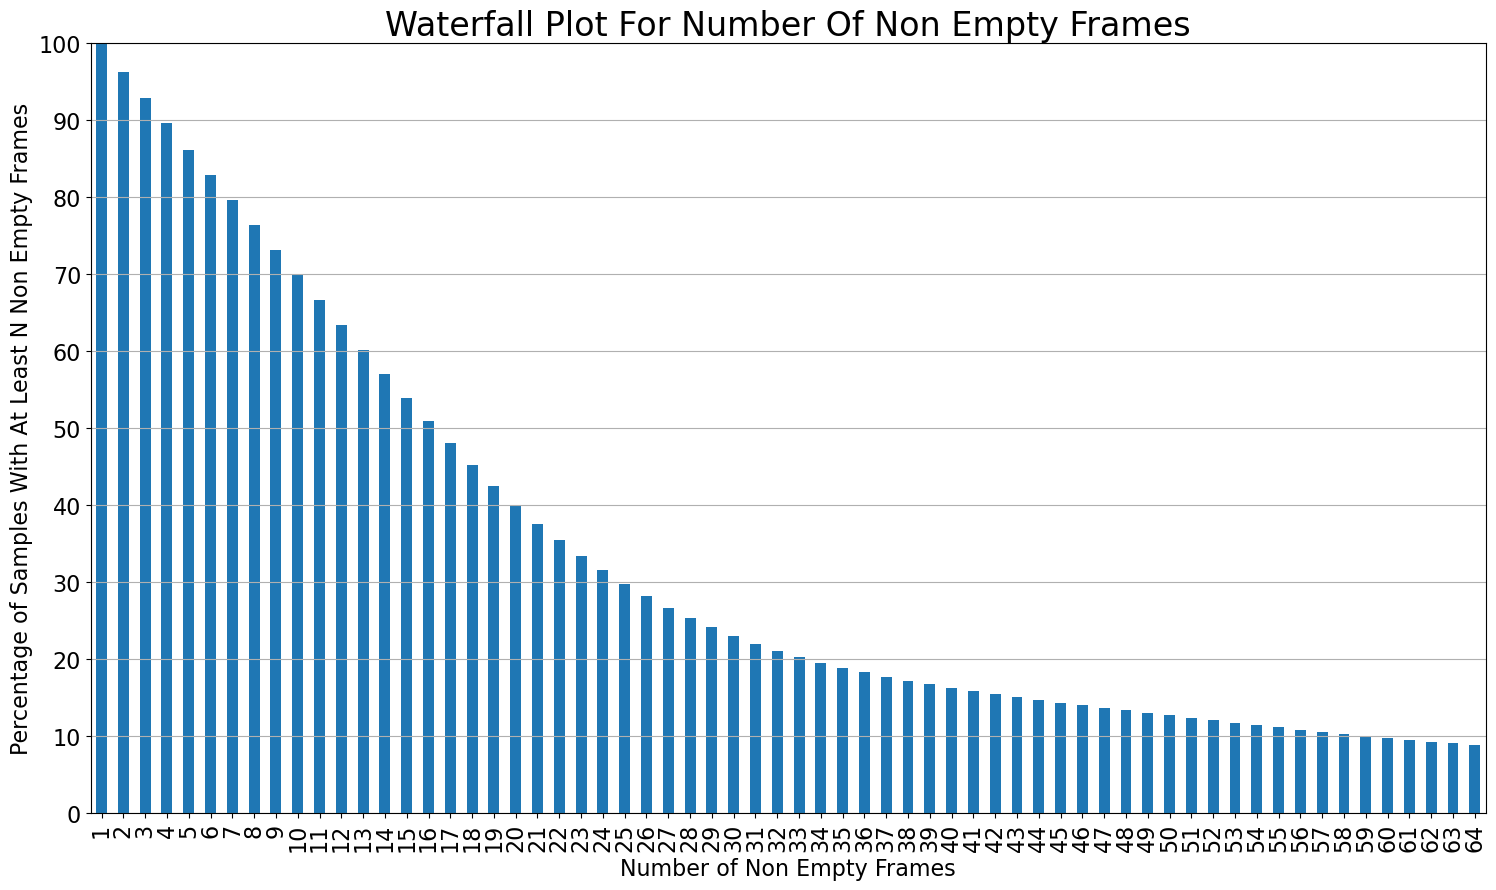

In [29]:
# Vast majority of samples fits has less than 32 non empty frames
N_EMPTY_FRAMES = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum(axis=1) 
N_EMPTY_FRAMES_WATERFALL = []
for n in tqdm(range(1,INPUT_SIZE+1)):
    N_EMPTY_FRAMES_WATERFALL.append(sum(N_EMPTY_FRAMES >= n) / len(NON_EMPTY_FRAME_IDXS_TRAIN) * 100)

plt.figure(figsize=(18,10))
plt.title('Waterfall Plot For Number Of Non Empty Frames')
pd.Series(N_EMPTY_FRAMES_WATERFALL).plot(kind='bar')
plt.grid(axis='y')
plt.xticks(np.arange(INPUT_SIZE), np.arange(1, INPUT_SIZE+1))
plt.xlabel('Number of Non Empty Frames', size=16)
plt.yticks(np.arange(0, 100+10, 10))
plt.ylim(0, 100)
plt.ylabel('Percentage of Samples With At Least N Non Empty Frames', size=16)
plt.show()

# Percentage of Frames Filled

In [30]:
# Percentage of frames filled, this is the maximum fill percentage of each landmark
P_DATA_FILLED = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum() / NON_EMPTY_FRAME_IDXS_TRAIN.size * 100
print(f'P_DATA_FILLED: {P_DATA_FILLED:.2f}%')

P_DATA_FILLED: 33.59%


# Feature Statistics - Lips

In [31]:
# Percentage of Lips Measurements
P_LEFT_LIPS_MEASUREMENTS = (X_train[:,:,LIPS_IDXS] != 0).sum() / X_train[:,:,LIPS_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_LIPS_MEASUREMENTS: {P_LEFT_LIPS_MEASUREMENTS:.2f}%')

P_LEFT_LIPS_MEASUREMENTS: 99.34%


The purpose of the code below is to determine the average and variability of the lips. It relies on the numpy and matplotlib libraries. Within these libraries, the np.transpose function alters the dimensions of the X_train array from (number of samples, number of time steps, number of features) to (number of features, number of time steps, number of samples). Subsequently, the reshape function modifies it into a shape of (number of features, number of time steps, number * number of samples). Lastly, for each feature and sample, the mean and standard deviation of the non-zero elements are calculated and stored in the arrays LIPS_MEAN_X, LIPS_MEAN_Y, LIPS_STD_X, and LIPS_STD_Y. These arrays are ultimately merged into the LIPS_MEAN and LIPS_STD arrays, which are then returned as the function's output.

  0%|          | 0/40 [00:00<?, ?it/s]

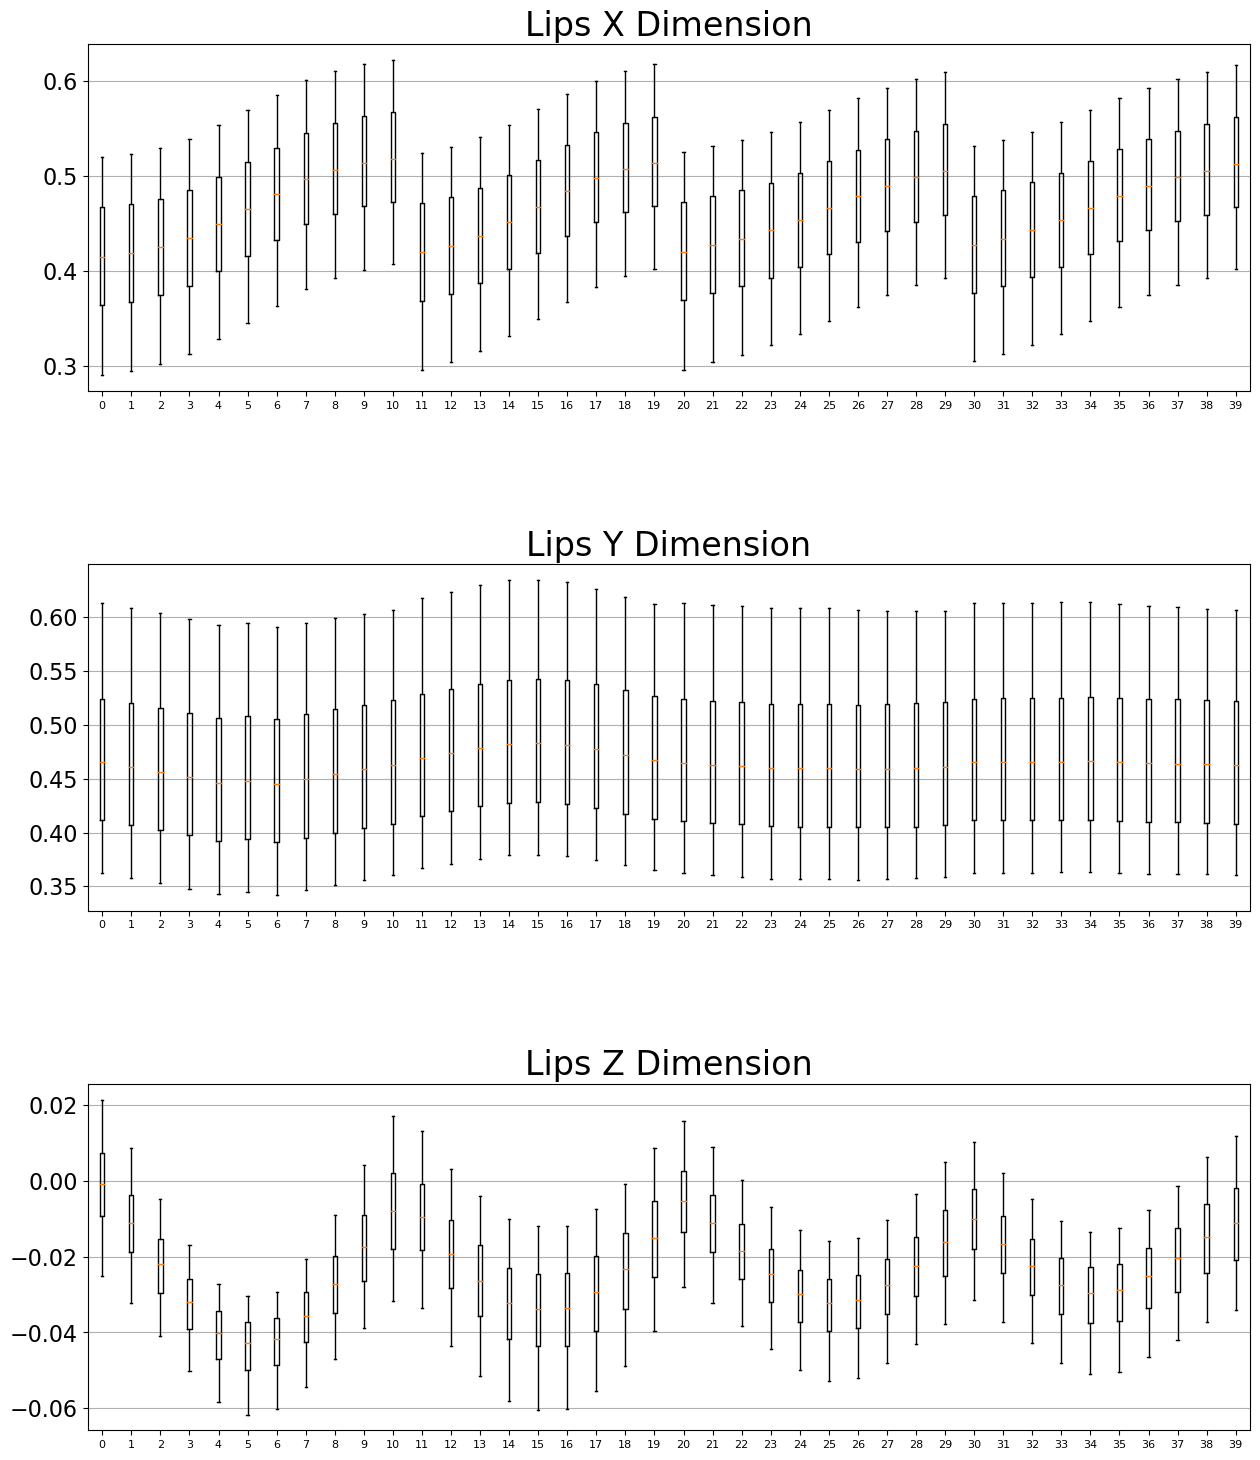

In [32]:
def get_lips_mean_std():
    # LIPS
    LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LIPS_MEAN_X[col] = v.mean()
                LIPS_STD_X[col] = v.std()
            if dim == 1: # Y
                LIPS_MEAN_Y[col] = v.mean()
                LIPS_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, ['x','y','z']):
        ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
    LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T
    
    return LIPS_MEAN, LIPS_STD

LIPS_MEAN, LIPS_STD = get_lips_mean_std()

# Feature Statistics - Hands

In [33]:
# Verify Normalised to Left Hand Dominant
P_LEFT_HAND_MEASUREMENTS = (X_train[:,:,LEFT_HAND_IDXS] != 0).sum() / X_train[:,:,LEFT_HAND_IDXS].size / P_DATA_FILLED * 1e4
# P_RIGHT_HAND_MEASUREMENTS = (X_train[:,:,RIGHT_HAND_IDXS] != 0).sum() / X_train[:,:,RIGHT_HAND_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_HAND_MEASUREMENTS: {P_LEFT_HAND_MEASUREMENTS:.2f}%')

P_LEFT_HAND_MEASUREMENTS: 100.00%


  0%|          | 0/21 [00:00<?, ?it/s]

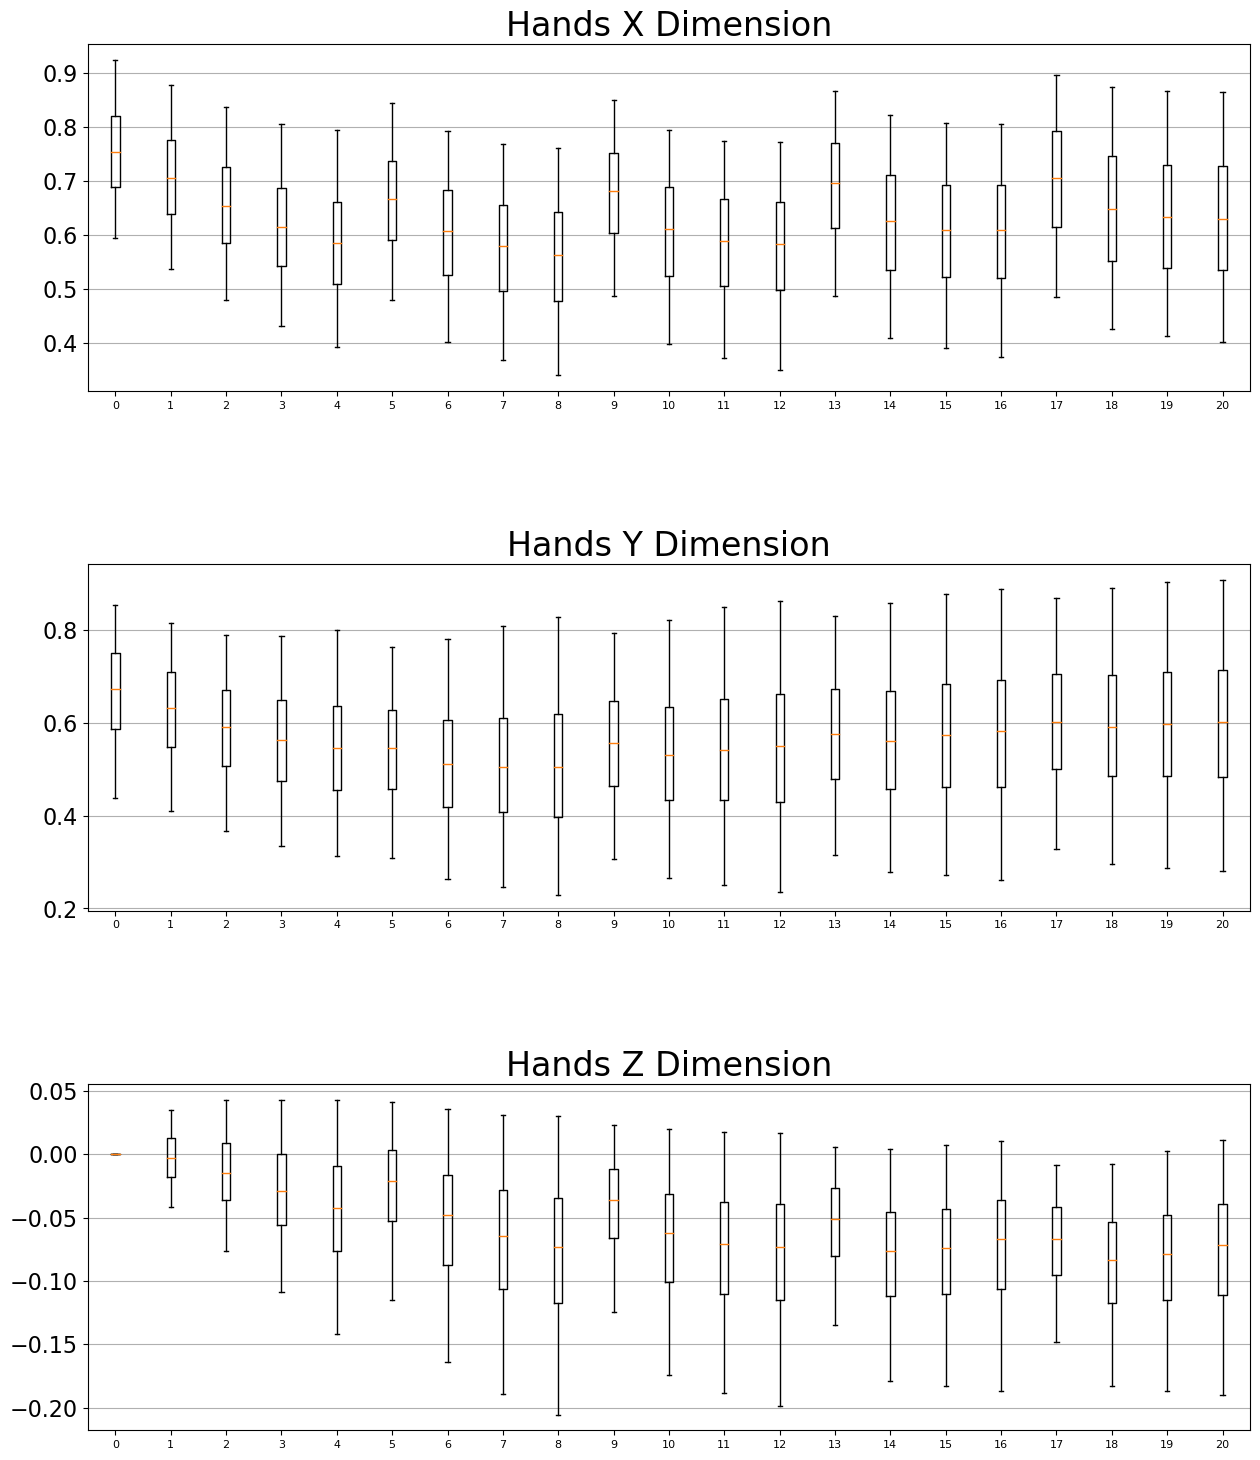

In [34]:
def get_left_right_hand_mean_std():
    # LEFT HAND
    LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_HAND_IDXS], [2,3,0,1]).reshape([LEFT_HAND_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, ['x','y','z']):
        ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
    LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
    
    return LEFT_HANDS_MEAN, LEFT_HANDS_STD

LEFT_HANDS_MEAN, LEFT_HANDS_STD = get_left_right_hand_mean_std()

# Feature Statistics - Pose

In [35]:
# Percentage of Lips Measurements
P_POSE_MEASUREMENTS = (X_train[:,:,POSE_IDXS] != 0).sum() / X_train[:,:,POSE_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_POSE_MEASUREMENTS: {P_POSE_MEASUREMENTS:.2f}%')

P_POSE_MEASUREMENTS: 100.00%


  0%|          | 0/5 [00:00<?, ?it/s]

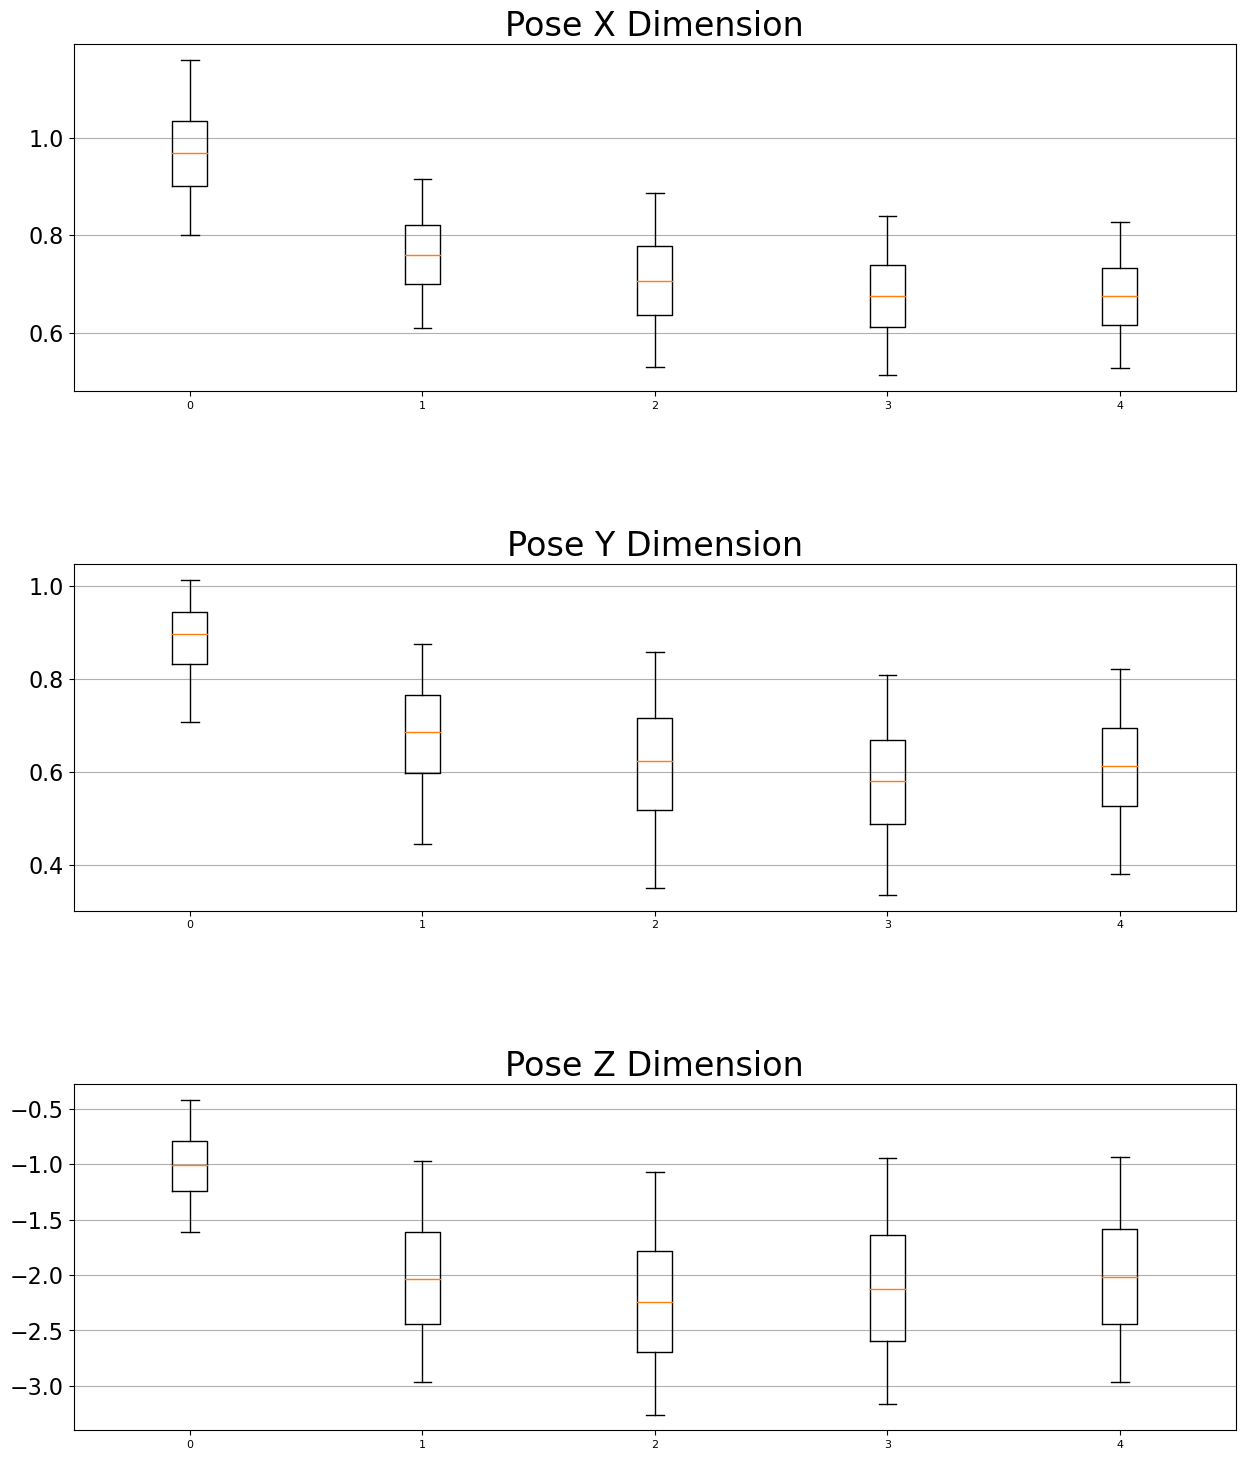

In [36]:
def get_pose_mean_std():
    # POSE
    POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                POSE_MEAN_X[col] = v.mean()
                POSE_STD_X[col] = v.std()
            if dim == 1: # Y
                POSE_MEAN_Y[col] = v.mean()
                POSE_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, ['x','y','z']):
        ax.set_title(f'Pose {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
    POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T
    
    return POSE_MEAN, POSE_STD

POSE_MEAN, POSE_STD = get_pose_mean_std()

# Samples


This code introduces a generator function called "get_train_batch_all_signs" designed to create a specific number (n) of training batches encompassing all sign language signs.

The function accepts inputs such as a sign language dataset (X and y), a set of frame indices that are not empty (NON_EMPTY_FRAME_IDXS), and the desired batch size denoted by the number of all sign language tokens (n). It generates a training batch comprising of NUM_CLASSES * n samples. This batch consists of a frames dictionary and a non_empty_frame_idxs dictionary, which respectively hold the sign language frames for each sample and the corresponding indices of non-empty frames. Additionally, the y_batch array contains the serial numbers of all sign language tokens.

The primary mechanism of this function involves iterating through all sign language tokens, selecting n samples from each token, and appending them to the batch array. The generator continues this looping process, ensuring a continuous supply of training data for the model throughout its training phase.

In [37]:
# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=4):
    # Arrays to store batch in
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)
    
    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)
            
    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]
        
        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [38]:
dummy_dataset = get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN)
X_batch, y_batch = next(dummy_dataset)

for k, v in X_batch.items():
    print(f'{k} shape: {v.shape}, dtype: {v.dtype}')

# Batch shape/dtype
print(f'y_batch shape: {y_batch.shape}, dtype: {y_batch.dtype}')
# Verify each batch contains each sign exactly N times
display(pd.Series(y_batch).value_counts().to_frame('Counts'))

frames shape: (1000, 64, 66, 3), dtype: float32
non_empty_frame_idxs shape: (1000, 64), dtype: float32
y_batch shape: (1000,), dtype: int64


,Counts
0,4
171,4
158,4
159,4
160,4
...,...
88,4
89,4
90,4
91,4


The purpose of this code is to randomly select a specific number of samples from the X_train and y_train datasets in order to create a training batch encompassing all sign language markers.

The generator function, get_train_batch_all_signs, establishes an endlessly looping generator that generates training batches including all sign language tokens. As a test example, dummy_dataset is a batch derived from this generator, which comprises dictionaries X_batch, y_batch, and NON_EMPTY_FRAME_IDXS_TRAIN, as well as a constant (4) indicating the total number of sign language tokens.

Within the aforementioned code, X_batch is a dictionary that contains frames and non_empty_frame_idxs dictionaries. The shapes and data types of these dictionaries are printed. Furthermore, the shape and data type of the y_batch array are also displayed. Finally, the code verifies that each sign language sign is included exactly 4 times by utilizing the pd.Series(y_batch).value_counts() function.

# Model Config

This code defines some constants and variables for the machine learning model.

`LAYER_NORM_EPS` is a constant that sets the epsilon value for layer normalization.

`LIPS_UNITS`, `HANDS_UNITS`, `POSE_UNITS` and `UNITS` are variables used to set the number of dense layer units for keypoints, final embedding and transformer embedding size.

`NUM_BLOCKS` and `MLP_RATIO` are variables that set the number of transformer blocks and MLP ratios.

`EMBEDDING_DROPOUT`, `MLP_DROPOUT_RATIO` and `CLASSIFIER_DROPOUT_RATIO` are variables used to set dropout ratios for embeddings, MLPs and classifiers.

`INIT_HE_UNIFORM`, `INIT_GLOROT_UNIFORM` and `INIT_ZEROS` are variables, initializers for setting weights.

`GELU` is a variable used to set the activation function.

The last line prints the value of `UNITS`.

In [39]:
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512

# Transformer
##mlp_ratio represents the first fully connected layer ascending channel multiple；
NUM_BLOCKS = 2
MLP_RATIO = 4

# Dropout
#The very important nature of the model is non-linearity,
#At the same time, for the generalization ability of the model, it is necessary to add random regularization, such as dropout (randomly set some outputs to 0, which is actually a random nonlinear activation in disguise)
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.15
CLASSIFIER_DROPOUT_RATIO = 0.00

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

print(f'UNITS: {UNITS}')

UNITS: 512


# Transformer

Need to implement transformer from scratch as TFLite does not support the native TF implementation of MultiHeadAttention. Start implementing the Transformer model (a neural network architecture used in natural language processing tasks), which includes the MultiHeadAttention layer. Since the MultiHeadAttention layer is a key component of the Transformer model, it may not be possible to use a pre-existing Transformer implementation in TensorFlow in TFLite if its implementation is not supported by TFLite. Therefore, you need to write the implementation code of Transformer yourself instead of relying on the implementation of the MultiHeadAttention layer in TensorFlow.

<img src="https://pic4.zhimg.com/v2-f6380627207ff4d1e72addfafeaff0bb_r.jpg">

Encoder: The input is the Embedding of the word, plus the position encoding, and then enters a unified structure, which can be looped many times (N times), that is to say, there are many layers (N layers). Each layer can be divided into an Attention layer and a fully connected layer, and some additional processing is added, such as Skip Connection, to make a skip connection, and then a Normalization layer is added. In fact, its own model is still very simple.
Decoder: The first input is the prefix information, and the subsequent one is the Embedding produced last time, adding the position code, and then entering a module that can be repeated many times. This module can be divided into three parts. The first part is also the Attention layer, the second part is cross Attention, not Self-Attention, and the third part is the fully connected layer. Also used skip connection and Normalization.
Output: The final output must pass through the Linear layer (full connection layer), and then predict through softmax.

The Encoder part is a stack of N identical structures, and each structure can be subdivided into the following structures:

1. Perform embedding (word embedding) on ​​the input one-hot encoded samples
2. Add location code
3. Introduce self-attention of multi-head mechanism
4. Add the input and output of self-attention (residual network structure)
5. Layer Normalization (layer normalization), normalize the data at all times
6. Feedforword neural network structure
7. Add the input and output of Feedforword (residual network structure)
8. Layer Normalization, normalize the data at all times
9. Repeat the structure of N layers 3-8

The Decoder part is also a stack of N identical structures, and each structure can be subdivided into the following structures:

1. Perform embedding (word embedding) on ​​the input one-hot encoded samples
2. Add location code
3. Introduce self-attention of multi-head mechanism
4. Add the input and output of self-attention (residual network structure)
5. Layer Normalization,
6. Standardize the data at all times and use the value obtained in the previous step as the value, and perform Self-Attenton with q and k obtained from the encoder
7. Add the input and output of self-attention (residual network structure)
8. Layer Normalization (layer normalization), normalize the data at all times
9. Feedforword neural network (Feedforword) structure
10. Add the input and output of Feedforword (residual network structure)
11. Layer Normalization, standardize the data at all times
12. Repeat the structure of N layer 3-11


The following piece of code represents the execution of MultiHeadAttention. It carries out a series of Dense layer transformations on the input tensor x, subsequently utilizing the scaled_dot_product function to process the modified tensors as Q, K, and V. This procedure facilitates the computation of the multi-head attention mechanism's output. To produce the ultimate output, the results from the multi-head attention mechanism are concatenated and subjected to a Dense layer for linear transformation, yielding the final multi_head_attention output.

In [40]:
# based on: https://stackoverflow.com/
#questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer

#scaled dot-product attention is an Attention mechanism in the Transformer model, which is a method of calculating Attention weights.
#In this method, the dot product of Query and Key is divided by a scaling factor, then normalized by the softmax function, and finally multiplied by Value to obtain the Attention output
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x, attention_mask):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

# Model Architecture

<img src="https://4143056590-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/assets%2F-LpO5sn2FY1C9esHFJmo%2F-M1uVIrSPBnanwyeV0ps%2F-M1uVKtDCvJ7TGjfZPuP%2Fencoder-decoder-2.jpg?generation=1583677008527428&alt=media">

Presented here is a Python Transformer model, an inheritance of the tf.keras.Model class. Its constructor features a num_blocks parameter, an integer denoting the count of Transformer blocks. Within the build function, numerous instances of Multi Head Attention and Multi Layer Perception are created and stored as class variables. In the call function, the input data is iterated over and forwarded to each Transformer block, which comprises both a Multi Head Attention and a Multi Layer Perception layer. This model's primary objective revolves around the execution of natural language processing tasks, including machine translation, text summarization, and more.

In [41]:
# Full Transformer
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))
        
    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x, attention_mask)
            x = x + mlp(x)
    
        return x

# Landmark Embedding
Key point embedding", where "Landmark" represents the key points of the face, and "Embedding" represents the process of mapping these key point information to a low-dimensional vector space. Therefore, the Chinese meaning of "Landmark Embedding" can be understood as "the face Embedding keypoint information into a low-dimensional vector space".

Landmark Embedding is a method of converting facial key point information into a low-dimensional vector representation. In tasks such as face recognition and facial expression recognition, Landmark Embedding is usually used to extract facial feature representations.

Specifically, Landmark Embedding maps the key point coordinates in the face image to a vector representation in a low-dimensional space. This vector representation can contain information about face shape, pose, and expression, and can be used to compare similarities or differences between different faces. Compared with directly using pixel information or high-dimensional feature vector representation, Landmark Embedding can improve the accuracy and robustness of face recognition and expression recognition.

In [42]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

# Embedding

In [43]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        
    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([3], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, pose0, non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((
            lips_embedding, left_hand_embedding, pose_embedding,
        ), axis=3)
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        max_frame_idxs = tf.clip_by_value(
                tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True),
                1,
                np.PINF,
            )
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / max_frame_idxs * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)
        
        return x

# Sparse Categorical Crossentropy With Label Smoothing

In [44]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25)

# Model

The model comprises two essential inputs: "frames" and "non_empty_frame_idxs." Within this context, "frames" represents a compilation of video data consisting of numerous frames, while "non_empty_frame_idxs" specifies the indices of frames containing actual content.

To facilitate effective training, the code intelligently employs a masking technique, meticulously selecting locations with valid frames. Consequently, solely these frames undergo the training process. The model adopts the transformative Transformer architecture, which amalgamates multiple layers equipped with attention mechanisms to process the input data.

Within this model's framework, each frame undergoes an embedding process that generates three distinct representations: LIPS, LEFT HAND, and POSE. These representations collectively construct the input for the Transformer, empowering it to extract meaningful information effectively.

Furthermore, the implementation incorporates additional inventive techniques, enriching the model's capabilities. These include random frame masking, category loss (which selectively eliminates certain features during classification), label smoothing, and more. By embracing these tricks, the model achieves improved performance and robustness.

Completing the model, an optimizer and evaluation metrics are integrated. The optimizer, AdamW, diligently optimizes the model during the training process. The evaluation metrics encompass sparse classification accuracy, top-k accuracy for sparse classification, and other suitable measures. These metrics facilitate a comprehensive assessment of the model's performance, ensuring reliable and insightful evaluation.

In [45]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, N_COLS, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    
    # Padding Mask
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    
    # Random Frame Masking
    mask = tf.where(
        (tf.random.uniform(tf.shape(mask0)) > 0.25) & tf.math.not_equal(mask0, 0.0),
        1.0,
        0.0,
    )
    
    # Correct Samples Which are all masked now...
    mask = tf.where(
        tf.math.equal(tf.reduce_sum(mask, axis=[1,2], keepdims=True), 0.0),
        mask0,
        mask,
    )
    
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,INPUT_SIZE, N_COLS, 2])
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    # POSE
    pose = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 5, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )
    
    # Flatten
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 5*2])
        
    # Embedding
    x = Embedding()(lips, left_hand, pose, non_empty_frame_idxs)
    
    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)
    
    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Sparse Categorical Cross Entropy With Label Smoothing
    loss = scce_with_ls
    
    #Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    
    #The learning rate is 1e-3, the weight decay is 1e-5, and the gradient clipping threshold is 1.0
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

In [46]:
tf.keras.backend.clear_session()

model = get_model()

In [47]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               
 er)                                                                                              
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 64, 1)        0           ['tf.cast[0][0]']            

# Weight Initialization

# NaN Values In Prediction: 0


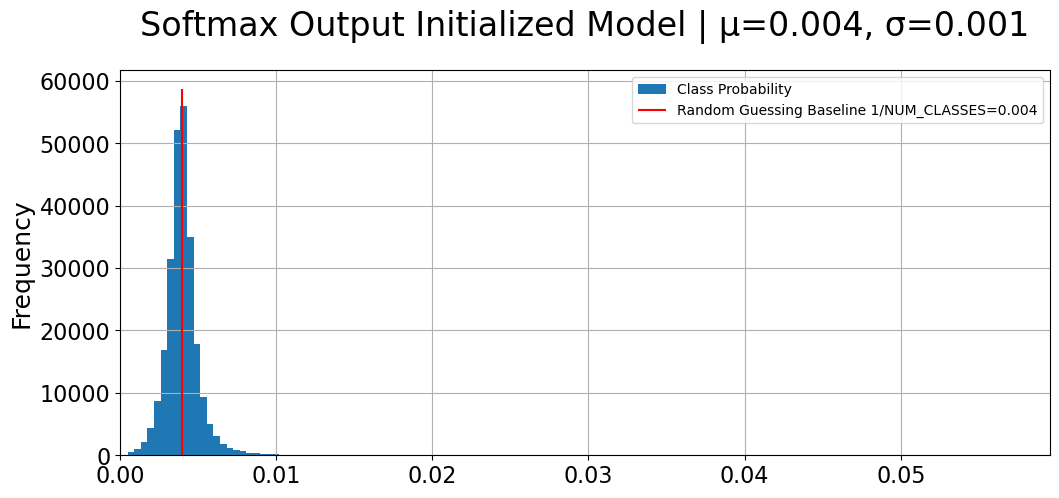

In [48]:
y_pred = model.predict_on_batch(X_batch).flatten()
print(f'# NaN Values In Prediction: {np.isnan(y_pred).sum()}')
    
plt.figure(figsize=(12,5))
plt.title(f'Softmax Output Initialized Model | µ={y_pred.mean():.3f}, σ={y_pred.std():.3f}', pad=25)
pd.Series(y_pred).plot(kind='hist', bins=128, label='Class Probability')
plt.xlim(0, max(y_pred) * 1.1)
plt.vlines([1 / NUM_CLASSES], 0, plt.ylim()[1], color='red', label=f'Random Guessing Baseline 1/NUM_CLASSES={1 / NUM_CLASSES:.3f}')
plt.grid()
plt.legend()
plt.show()

# Learning Rate Scheduler

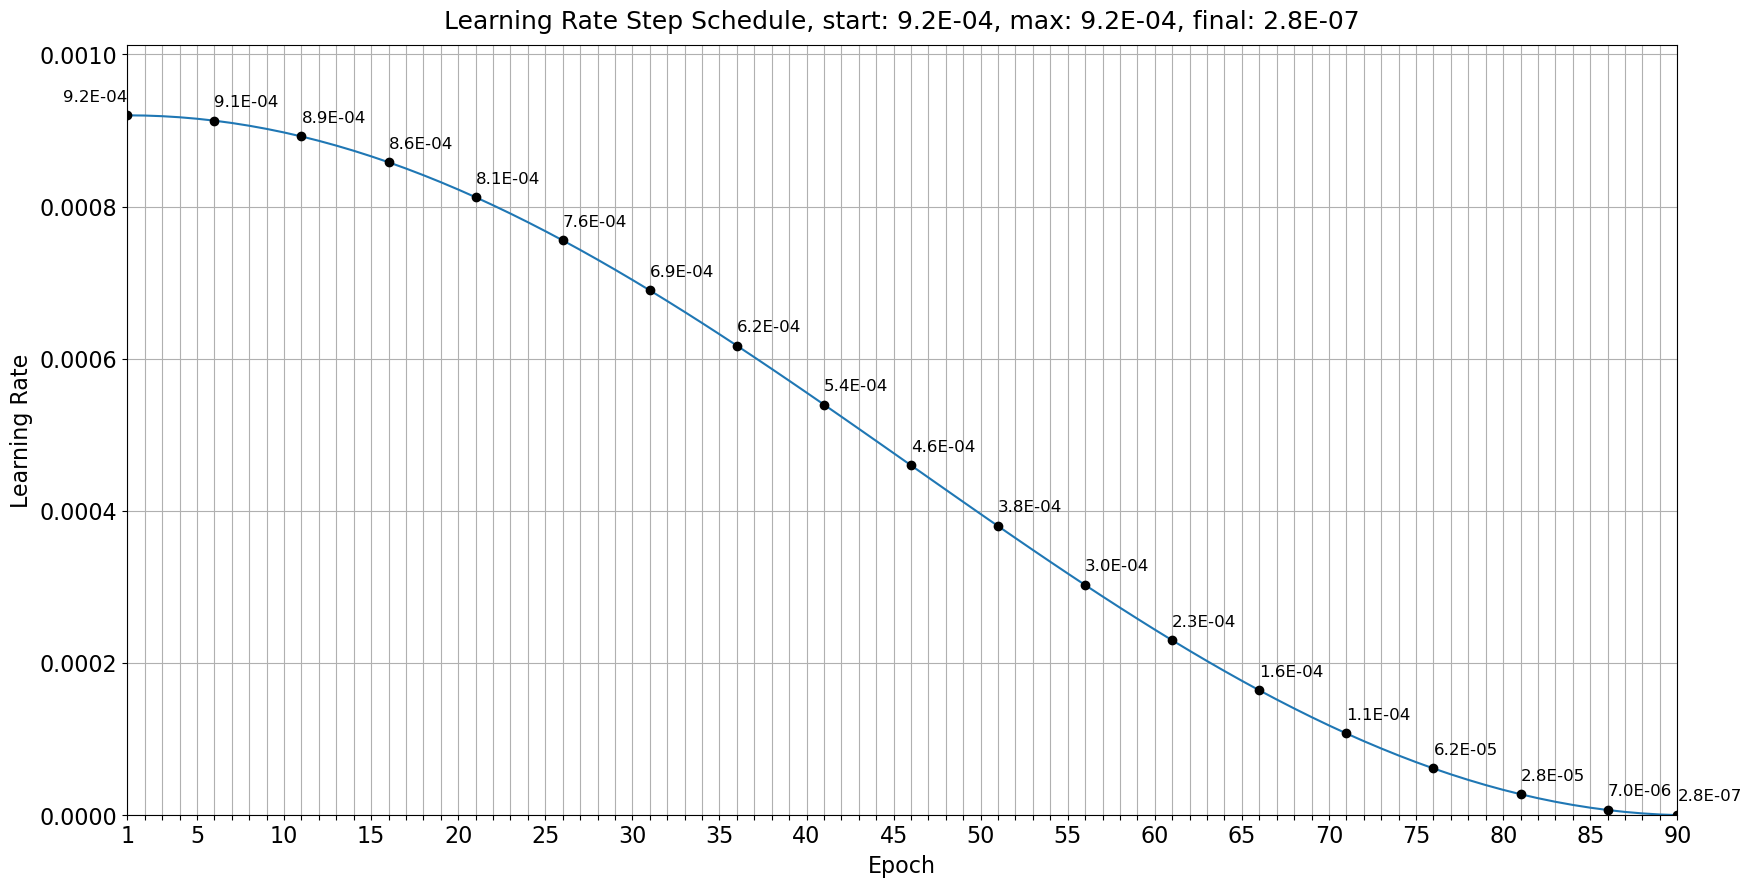

In [49]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max
    
def visualize_learning_rate(lrate_plan, total_epochs):
    figure = plt.figure(figsize=(20, 10))
    plt.plot([None] + lrate_plan + [None])
    
    # X-axis labels
    epoch_range = np.arange(1, total_epochs + 1)
    x_axis_labels = [i if total_epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, total_epochs + 1)]
    plt.xlim([1, total_epochs])
    plt.xticks(epoch_range, x_axis_labels)
    
    # Expand y-limit for better visualization
    plt.ylim([0, max(lrate_plan) * 1.1])
    
    # Title
    lrate_info = f'start: {lrate_plan[0]:.1E}, max: {max(lrate_plan):.1E}, final: {lrate_plan[-1]:.1E}'
    plt.title(f'Learning Rate Step Schedule, {lrate_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, value in enumerate(lrate_plan):
        if total_epochs <= 40 or x % 5 == 0 or x is total_epochs - 1:
            ha = 'right' if x < len(lrate_plan) - 1 and lrate_plan[x - 1] < value else 'left'
            plt.plot(x + 1, value, 'o', color='black')
            offset_y = (max(lrate_plan) - min(lrate_plan)) * 0.02
            plt.annotate(f'{value:.1E}', xy=(x + 1, value + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Define learning rate for the encoder
LEARNING_RATE_PLAN = [lrfn(step, num_warmup_steps=0, lr_max=0.00092, num_cycles=0.50) for step in range(N_EPOCHS)]
# Visualize Learning Rate Schedule
visualize_learning_rate(LEARNING_RATE_PLAN, total_epochs=N_EPOCHS)
# Define Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LEARNING_RATE_PLAN[step], verbose=1)

# Weight Decay Callback

In [50]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=0.054):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Train

In [51]:
# Clear all models in GPU
tf.keras.backend.clear_session()

# Get new fresh model
model = get_model()

# Sanity Check
model.summary()

# Actual Training
history = model.fit(
        x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
        steps_per_epoch=len(X_train) // (NUM_CLASSES * 4),
        epochs=N_EPOCHS,
        batch_size=512,
        validation_data=validation_data,
        callbacks=[
            lr_callback,
            WeightDecayCallback(),
        ],
    )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               
 er)                                                                                              
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 64, 1)        0           ['tf.cast[0][0]']            

In [52]:
# Save Model Weights
model.save_weights('model.h5')

In [53]:
y_val_pred = model.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(NUM_CLASSES)]

446/446 - 8s - 8s/epoch - 19ms/step


# Landmark Attention Weights

In [54]:
# Landmark Weights
for w in model.get_layer('embedding').weights:
    if 'landmark_weights' in w.name:
        weights = scipy.special.softmax(w)

landmarks = ['lips_embedding', 'left_hand_embedding', 'pose_embedding']

for w, lm in zip(weights, landmarks):
    print(f'{lm} weight: {(w*100):.1f}%')

lips_embedding weight: 28.5%
left_hand_embedding weight: 47.9%
pose_embedding weight: 23.6%


# Classification Report

In [59]:
import sklearn
def print_classification_report():
    # Classification report for all signs
    classification_report = sklearn.metrics.classification_report(
            y_val,
            y_val_pred,
            target_names=labels,
            output_dict=True,
        )
    # Round Data for better readability
    classification_report = pd.DataFrame(classification_report).T
    classification_report = classification_report.round(2)
    classification_report = classification_report.astype({
            'support': np.uint16,
        })
    # Add signs
    classification_report['sign'] = [e if e in SIGN2ORD else -1 for e in classification_report.index]
    classification_report['sign_ord'] = classification_report['sign'].apply(SIGN2ORD.get).fillna(-1).astype(np.int16)
    # Sort on F1-score
    classification_report = pd.concat((
        classification_report.head(NUM_CLASSES).sort_values('f1-score', ascending=False),
        classification_report.tail(3),
    ))

    pd.options.display.max_rows = 999
    display(classification_report)

In [60]:
print_classification_report()

,precision,recall,f1-score,support,sign,sign_ord
frog,0.98,0.98,0.98,54,frog,90
police,1.00,0.93,0.97,60,police,174
doll,1.00,0.95,0.97,61,doll,59
food,0.92,1.00,0.96,57,food,87
owl,0.93,0.98,0.96,57,owl,165
shirt,0.91,0.98,0.95,54,shirt,195
airplane,0.90,1.00,0.95,57,airplane,2
nose,0.92,0.98,0.95,58,nose,155
brown,0.90,0.98,0.94,58,brown,31
for,0.95,0.93,0.94,57,for,88


# Training History

draw the training curve

In [61]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

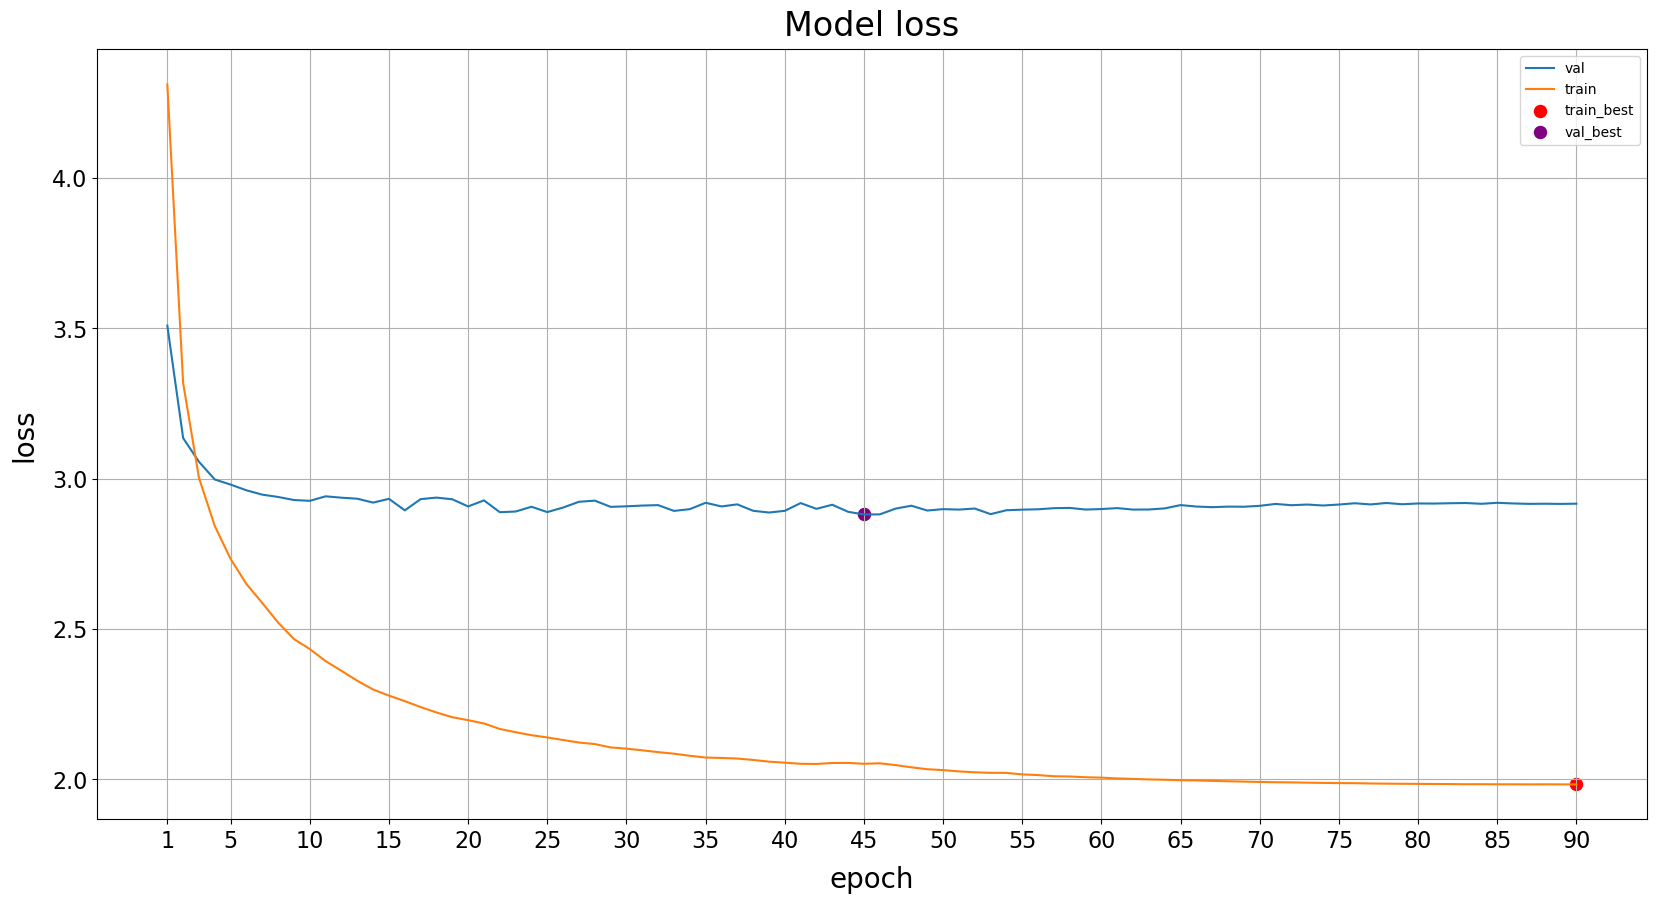

In [62]:
plot_history_metric('loss', f_best=np.argmin)

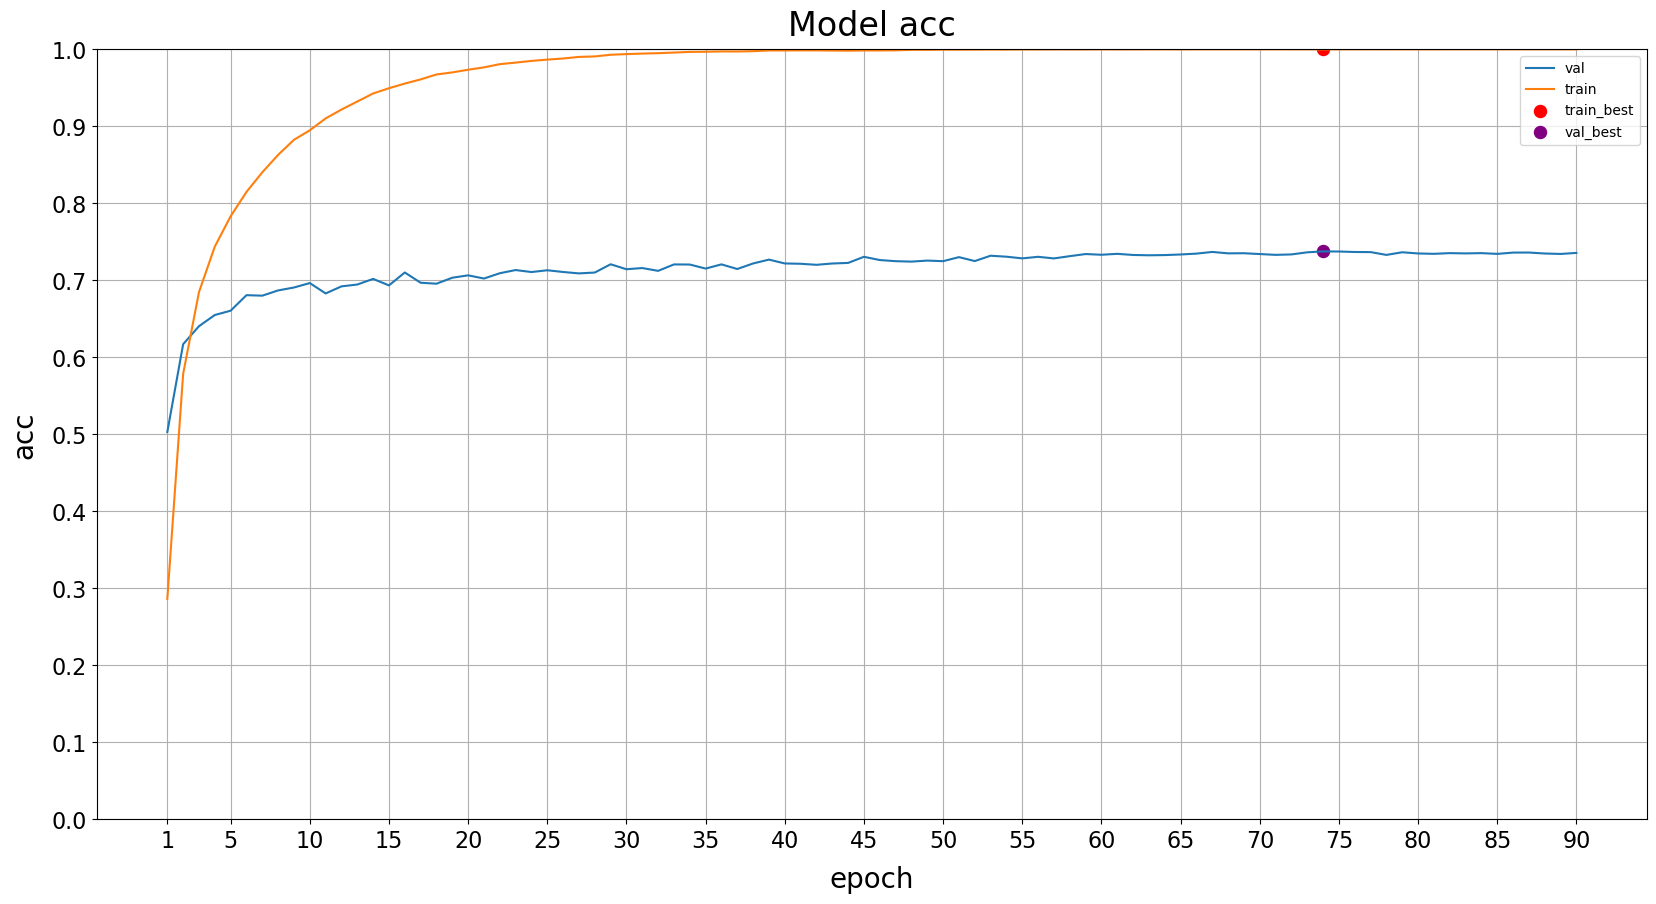

In [63]:
plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

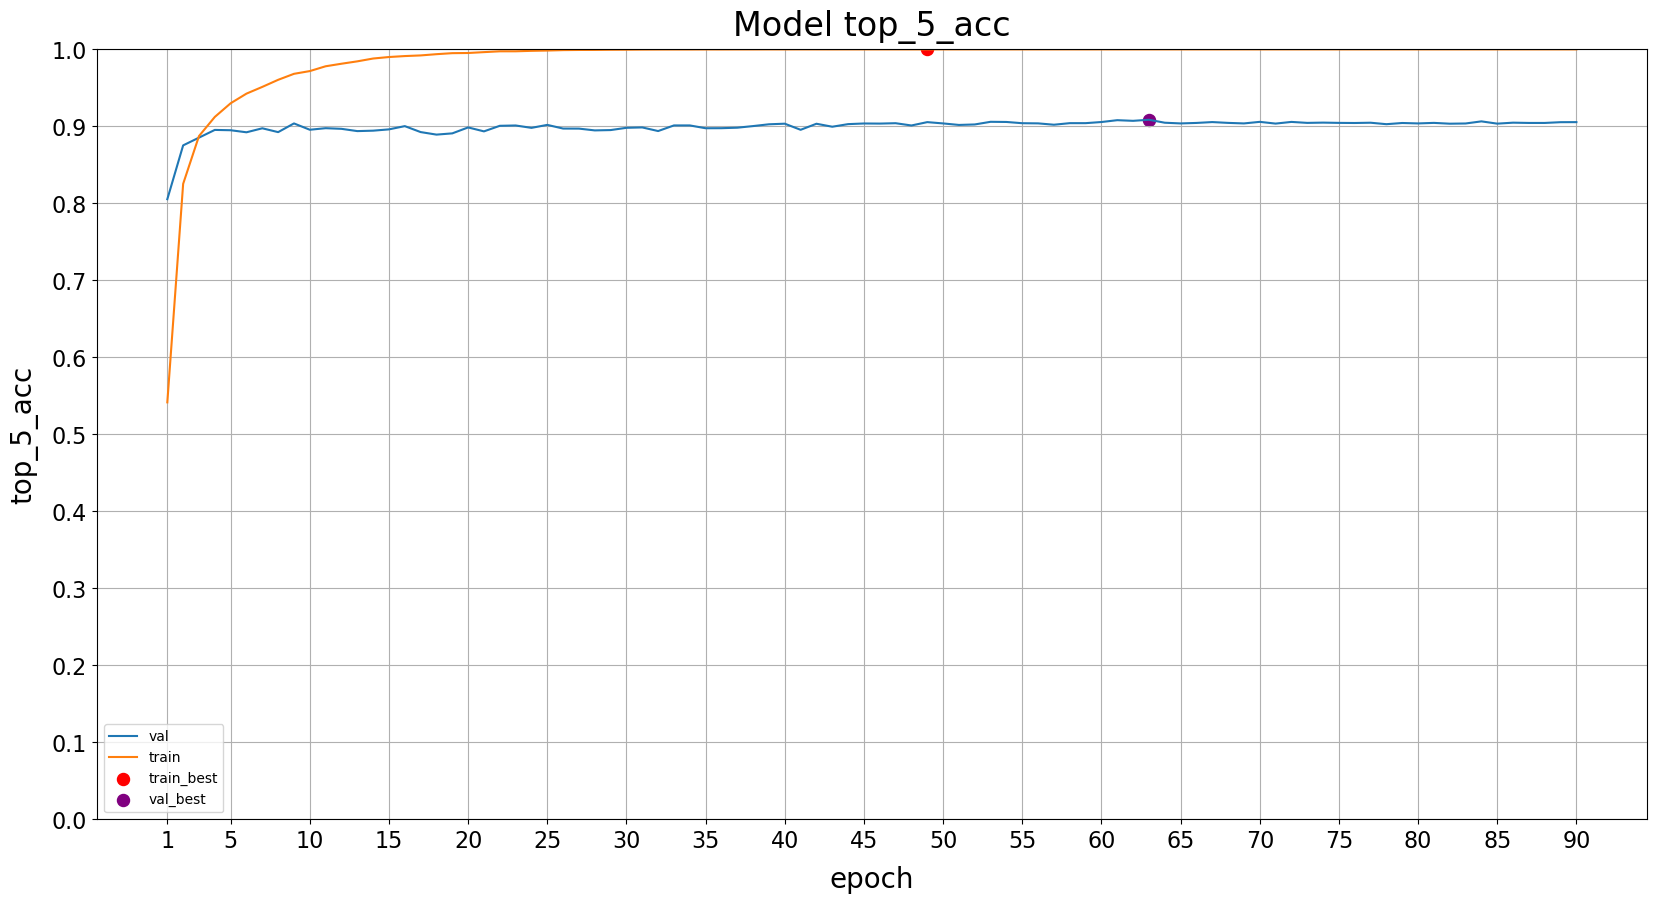

In [64]:
plot_history_metric('top_5_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

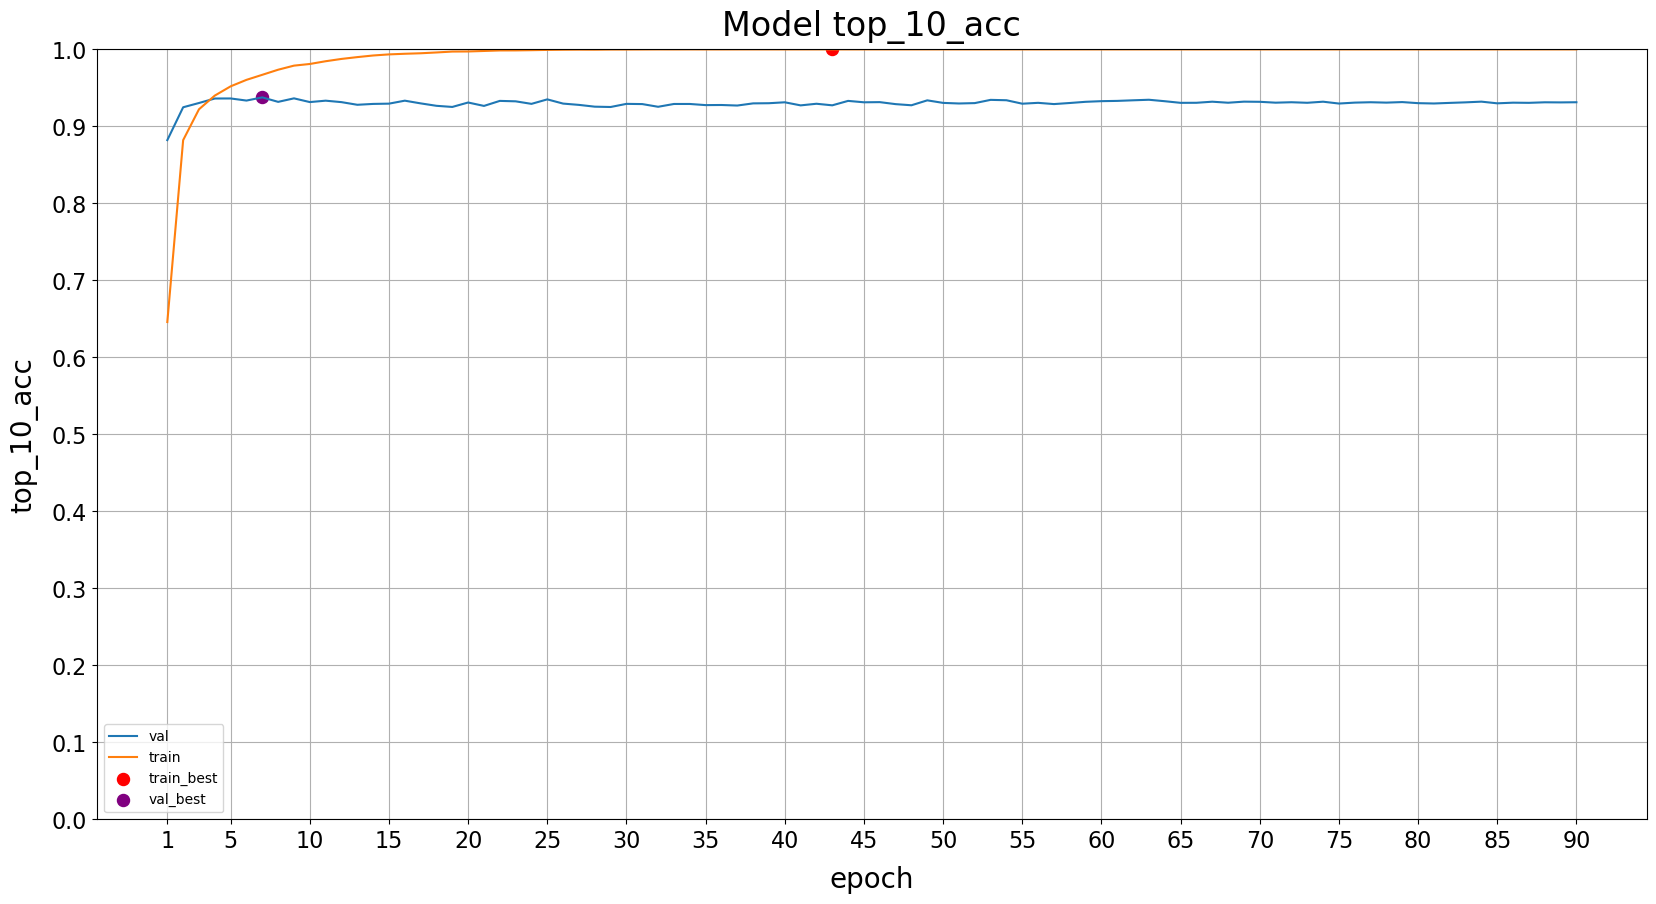

In [65]:
plot_history_metric('top_10_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

# Submission

Submission code loosley based on [this notebook](https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline#baseline) by [Darien Schettler
](https://www.kaggle.com/dschettler8845)

The PreprocessLayer class is a custom layer inherited from TensorFlow's tf.keras.layers.Layer class for processing data in TensorFlow Lite models. This custom layer contains functions for processing input data.

First, in the __init__ method, the layer creates a constant named normalisation_correction. This constant is a matrix with the number of rows equal to the number of landmarks of a specific type in the data, and 3 columns for the x, y, and z coordinates. This matrix is used to correct the camera's shooting direction, swapping left and right hands.

The layer also defines a method called pad_edge, which is used to pad a given tensor with a certain number of repeated elements on the left or right side.

Next, the layer decorates a call method with the @tf.function decorator to handle input data.

The method first calculates the number of frames (N_FRAMES0) in the input data. It then finds the dominant hand landmarks in the data by computing the sum of coordinates for left and right hands, and determines the frames to keep by counting the non-NaN values in the dominant hand for each frame. It collects the landmark data from the input data using these indices.

The method then converts the data type of the frame indices from integers to floats and normalizes them to start from 0. It calculates the number of frames (N_FRAMES) again from the filtered data and collects the landmarks of a specific type from these data. If the number of frames in the data is less than the specified input size (INPUT_SIZE), it pads with -1 to extend the number of frames to the specified input size and replaces NaN values with 0. If the number of frames is greater than the specified input size, it reduces it to the specified input size using repeated data and fills any missing data.

Finally, the method returns the processed data and the corresponding frame indices.

In [66]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        normalisation_correction = tf.constant([
                    # Add 0.50 to left hand (original right hand) and substract 0.50 of right hand (original left hand)
                    [0] * len(LIPS_IDXS) + [0.50] * len(LEFT_HAND_IDXS) + [0.50] * len(POSE_IDXS),
                    # Y coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                    # Z coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                ],
                dtype=tf.float32,
            )
        self.normalisation_correction = tf.transpose(normalisation_correction, [1,0])
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Find dominant hand by comparing summed absolute coordinates
        left_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1))
        right_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1))
        left_dominant = left_hand_sum >= right_hand_sum
        
        # Count non NaN Hand values in each frame for the dominant hand
        if left_dominant:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        else:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        
        # Find frames indices with coordinates of dominant hand
        non_empty_frames_idxs = tf.where(frames_hands_non_nan_sum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        # Filter frames
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32)
        # Normalize to start with 0
        non_empty_frames_idxs -= tf.reduce_min(non_empty_frames_idxs)
        
        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]
        
        # Gather Relevant Landmark Columns
        if left_dominant:
            data = tf.gather(data, LANDMARK_IDXS_LEFT_DOMINANT0, axis=1)
        else:
            data = tf.gather(data, LANDMARK_IDXS_RIGHT_DOMINANT0, axis=1)
            data = (
                    self.normalisation_correction + (
                        (data - self.normalisation_correction) * tf.where(self.normalisation_correction != 0, -1.0, 1.0))
                )
        
        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < INPUT_SIZE**2:
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, non_empty_frames_idxs
    
preprocess_layer = PreprocessLayer()

In [70]:
# TFLite model for submission
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_ROWS, N_DIMS], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Preprocess Data
        x, non_empty_frame_idxs = self.preprocess_layer(inputs)
        # Add Batch Dimension
        x = tf.expand_dims(x, axis=0)
        non_empty_frame_idxs = tf.expand_dims(non_empty_frame_idxs, axis=0)
        # Make Prediction
        outputs = self.model({ 'frames': x, 'non_empty_frame_idxs': non_empty_frame_idxs })
        # Squeeze Output 1x250 -> 250
        outputs = tf.squeeze(outputs, axis=0)

        # Return a dictionary with the output tensor
        return {'outputs': outputs}

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)

# Sanity Check
demo_raw_data = load_relevant_data_subset(train['path'].values[5])
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)["outputs"]
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
demo_prediction = demo_output.numpy().argmax()
print(f'demo_prediction: {demo_prediction}, correct: {train.iloc[0]["sign_ord"]}')

demo_raw_data shape: (30, 543, 3), dtype: float32
demo_output shape: (250,), dtype: <dtype: 'float32'>
demo_prediction: 67, correct: 25


In [71]:
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)
    
# Zip Model
!zip submission.zip /kaggle/working/model.tflite

  adding: kaggle/working/model.tflite (deflated 8%)


In [72]:
# Verify TFLite model can be loaded and used for prediction
!pip install tflite-runtime
import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter("/kaggle/working/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

output = prediction_fn(inputs=demo_raw_data)
sign = output['outputs'].argmax()

print("PRED : ", ORD2SIGN.get(sign), f'[{sign}]')
print("TRUE : ", train.sign.values[0], f'[{train.sign_ord.values[0]}]')

PRED :  duck [67]
TRUE :  blow [25]
